!pip install -U pip
!pip install --use-pep517 suod 
!pip install polars catboost yake threadpoolctl 
!pip install polars-splitters

## Блок загрузки

In [1]:
import polars as pl
from polars_splitters import split_into_train_eval
import polars.selectors as cs
import numpy as np
import pandas as pd

from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import select_threshold


from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest

import requests
import zipfile
import io

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import re
import gc
import yake
import nltk
from joblib import Parallel, delayed

from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
len_word = 10

RANDOM_STATE = 255

try:
    from catboost.utils import get_gpu_device_count
    gpu_count = get_gpu_device_count()
except ImportError:
    gpu_count = 0

if gpu_count > 0:
    print(f"GPU доступен, количество устройств: {gpu_count}")
    task_type = 'GPU'
else:
    print("GPU недоступен, используем CPU")
    task_type = 'CPU'

from joblib import Parallel, delayed
n_jobs = 3
custom_stopwords = {"для", "в", "с","при","вы","не","от","что","это","на","к",'<li>','</li>','</b>','<b>','<br/>'
                    'from','and','on','to','for','with','that','this','what','who'}

stop_word = stop_words.union(custom_stopwords)

chunk_size = 1000
pattern_clean = re.compile(r'[^а-яА-ЯёЁa-zA-Z0-9\s\(\)\{\}\[\]]')

GPU доступен, количество устройств: 1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Блок функций обработки текста и phik

In [10]:
# n - количество слов колотые проверяются top - количество оставляемых слов
def clean_text(text):
    if not isinstance(text, str):
        return ''
    cleaned = pattern_clean.sub('', text)
    return cleaned.lower().strip()

def extract_words(text, max_len=100, stop_words=None, top_k=8,n=5):
    
    if not isinstance(text, str) or not text.strip():
        return ''
    
    shortened = text if len(text) <= max_len else text[:max_len]
    
    kw_extractor = yake.KeywordExtractor(n=n,top=top_k, lan="ru", stopwords=stop_words or set())
    keywords = kw_extractor.extract_keywords(shortened)
    if not keywords:
        return ''
    return keywords[0][0]
    
def process_text_chunk(texts_chunk, stop_words=stop_word, top_k=len_word, n_jobs=-1,n=3):
    gc.collect()
    results = Parallel(n_jobs=n_jobs)(delayed(extract_words)(text, max_len=100, stop_words=stop_words, top_k=top_k,n=n) for text in texts_chunk)
    
    gc.collect()
    return results

def chunker(seq, size):
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size]

def phik_pl(df_phik, interal_col): 
    
    display ('PHIK матрица ')
    phik_overview = df_phik.phik_matrix(interval_cols=interal_col, bins=5, quantile=True) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1,
        figsize=(16,14))
    
    return phik_overview

## Класс обработки текстовых и числовых даных

In [3]:
# Preprocessing pipeline
class DataPreprocessor:
    def __init__(self, col_text, col_num):
        self.col_text = col_text
        self.col_num = col_num
        self.tfidf = TfidfVectorizer(max_features=500)
        self.scaler = StandardScaler()

    def preprocess_text_columns(self, df: pl.DataFrame, chunk_size=1000) -> pl.DataFrame:
        for col in self.col_text:
            print(f"Обработка столбца {col}...")
            df = df.with_columns([pl.col(col).fill_null(f"No {col}").cast(pl.Utf8).alias(col)])
            texts = df[col].to_list()
            cleaned_texts = [clean_text(t) for t in texts]
            if col == 'name_rus':
                all_results = []
                for chunk in chunker(cleaned_texts, chunk_size):
                    chunk_results = process_text_chunk(chunk, top_k=5, n=5)
                    all_results.extend(chunk_results)
            else:
                all_results = []
                for chunk in chunker(cleaned_texts, chunk_size):
                    chunk_results = process_text_chunk(chunk, top_k=3, n=3)
                    all_results.extend(chunk_results)
            df = df.with_columns([pl.Series(all_results).alias(col)])
        return df

    def preprocess_numeric_columns0(self, df: pl.DataFrame) -> pl.DataFrame:
        for col in self.col_num:
            print(f"Обработка столбца {col}...")
            df = df.with_columns(pl.col(col).fill_null(0).alias(col))
        df = df.with_columns([
            (pl.col('seller_time_alive') == pl.col('item_time_alive')).alias('same_time'),
            (pl.col('ItemAvailableCount') == pl.col('ItemVarietyCount')).alias('same_count'),
            #((pl.col('ItemVarietyCount') - pl.col('ItemAvailableCount')) / (1 + pl.col('ItemAvailableCount'))).alias('Delta_Count')
        ])
        return df

    def preprogress_rating(self, df: pl.DataFrame) -> pl.DataFrame:
        rating_cols = [f"rating_{i}_count" for i in range(1, 6)]
        # Создаем алиасы для рейтингов без _count
        df = df.with_columns([pl.col(col).alias(col.replace('_count', '')) for col in rating_cols if col in df.columns])

        def categorize(col_name):
            return (
                pl.when(pl.col(col_name) == 0).then(pl.lit("no_data"))
                  .when((pl.col(col_name) > 0) & (pl.col(col_name) <= 4)).then(pl.lit("low"))
                  .when((pl.col(col_name) > 4) & (pl.col(col_name) <= 15)).then(pl.lit("some"))
                  .otherwise(pl.lit("many"))
                  .alias(col_name)
            )
        expressions = [categorize(col) for col in rating_cols if col in df.columns]
        df = df.with_columns(expressions)
        return df

    def preprocess_numeric_columns(self, df: pl.DataFrame, base_names: list, drop_true: bool = True) -> pl.DataFrame:
        expressions = []

        group_returns = []
        group_suffixes = []
        group_others = []
    
        for col_name in base_names:
            # Приоритетно определяем группу для признака
            if re.search(r'return', col_name, re.IGNORECASE):
                group_returns.append(col_name)
            elif re.search(r'(_?(7|30|90))$', col_name):
                group_suffixes.append(col_name)
            else:
                group_others.append(col_name)
    
        # Обработка признаков с 'returns'
        for col in group_returns:
            sales_base = col.lower().replace('returns', 'sales').replace('fake_', '')
            corresponding_sales = [c for c in df.columns if sales_base in c.lower()]
            for sales_col in corresponding_sales:
                if col in df.columns and sales_col in df.columns:
                    expressions.append((pl.col(col) / (pl.col(sales_col) + 1)).alias(f"{col}_to_{sales_col}"))
            if col in df.columns:
                expressions.append((pl.col(col) > 20).cast(pl.Int8).alias(f"{col}_high"))
                expressions.append(pl.when(pl.col(col) > 0).then(pl.col(col).log()).otherwise(0).alias(f"{col}_log"))
    
        # Обработка признаков с суффиксами 7,30,90
        suffixes = ['7', '30', '90']
        bases = set([re.sub(r'(_?(7|30|90))$', '', col) for col in group_suffixes])
        for base in bases:
            for i in range(len(suffixes) - 1):
                a = f"{base}{suffixes[i]}"
                b = f"{base}{suffixes[i + 1]}"
                if a in df.columns and b in df.columns:
                    expressions.append((pl.col(b) - pl.col(a)).alias(f"{base}_chg_{suffixes[i]}_{suffixes[i+1]}"))
            for suf in suffixes:
                col_suf = f"{base}{suf}"
                if col_suf in df.columns:
                    expressions.append(pl.when(pl.col(col_suf) > 0)
                       .then(pl.col(col_suf).log()).otherwise(0).alias(f"{col_suf}_log"))
    
        # Обработка остальных признаков
        for col in group_others:
            if col in df.columns:
                expressions.append(pl.when(pl.col(col) > 0)
                   .then(pl.col(col).log()).otherwise(0).alias(f"{col}_log"))
                if re.search(r'return', col, re.IGNORECASE):
                    expressions.append((pl.col(col) > 20).cast(pl.Int8).alias(f"{col}_high"))
    
        # Отдельно ratio для ItemAvailableCount / ItemVarietyCount
        if 'ItemAvailableCount' in df.columns and 'ItemVarietyCount' in df.columns:
            expressions.append((pl.col('ItemAvailableCount') / (pl.col('ItemVarietyCount') + 1)).alias('available_to_variety'))
    
        # Определяем, что нужно удалить
        columns_to_drop = base_names if drop_true else []
    
        df = df.with_columns(expressions)
        if drop_true:
            df = df.drop(columns_to_drop)
        return df   
    
    def preprocess_all(self, df: pl.DataFrame, base_names_num: list, drop_true: bool = True) -> pl.DataFrame:
        #df = self.preprocess_text_columns(df)
        #df = self.preprocess_numeric_columns0(df)
        for col in self.col_num:
            print(f"Обработка столбца {col}...")
            df = df.with_columns(pl.col(col).fill_null(0).alias(col))
        
        df = self.preprocess_numeric_columns(df, base_names_num,drop_true)
        df = self.preprogress_rating(df)
        return df


    

## Класс обработки CBLOF и iforest (с текстом и без))

In [4]:
# CBLOF и iforest  anomaly detection feature
class CBLOFAdder:

    def __init__(self, contamination=0.1, n_clusters=3, alpha=0.9, beta=5, tfidf_max_features=100):
        self.cblof = CBLOF(contamination=contamination, n_clusters=n_clusters, alpha=alpha, beta=beta)
        self.cblof2 = CBLOF(contamination=contamination, n_clusters=n_clusters, alpha=alpha, beta=beta)
        self.tfidf = TfidfVectorizer(max_features=tfidf_max_features)
        self.iforest = IForest(contamination=contamination, random_state=42)
        self.iforest2 = IForest(contamination=contamination, random_state=42)
        self.is_fitted = False

    def fit_tfidf(self, texts):
        return self.tfidf.fit_transform(texts).toarray()

    def transform_tfidf(self, texts):
        return self.tfidf.transform(texts).toarray()

    def prepare_features(self, df, numeric_cols, text_cols=None, fit_tfidf=True):
        X = df[numeric_cols].values
        if text_cols is not None:
            all_text_features = []
            for col in text_cols:
                if fit_tfidf:
                    features = self.fit_tfidf(df[col])
                else:
                    features = self.transform_tfidf(df[col])
                all_text_features.append(features)
            if all_text_features:
                text_features_stacked = np.hstack(all_text_features)
                X = np.hstack([X, text_features_stacked])
        return X

    def fit(self, X_with_text, X_without_text, typelof='CBLOF'):
        if typelof == 'CBLOF':
            self.cblof.fit(X_with_text)
            self.cblof2.fit(X_without_text)
        else:
            self.iforest.fit(X_with_text)
            self.iforest2.fit(X_without_text)
        self.is_fitted = True

    def predict(self, X, with_text=True, typelof='CBLOF'):
        assert self.is_fitted, "Модель не обучена"
        if with_text:
            if typelof == 'CBLOF':
                preds = self.cblof.predict(X)
            else:
                preds = self.iforest.predict(X)
        else:
            if typelof == 'CBLOF':
                preds = self.cblof2.predict(X)
            else:
                preds = self.iforest2.predict(X)
        return preds.reshape(-1, 1)

    def predict_proba(self, X, with_text=True, typelof='CBLOF'):
        assert self.is_fitted, "Модель не обучена"
        if with_text:
            if typelof == 'CBLOF':
                scores = self.cblof.decision_function(X)
            else:
                scores = self.iforest.decision_function(X)
        else:
            if typelof == 'CBLOF':
                scores = self.cblof2.decision_function(X)
            else:
                scores = self.iforest2.decision_function(X)
        return scores.reshape(-1, 1)

## Класс Catboost0 

In [5]:
#модель отбора harв признаков 
class CatBoostPipeline0:
    def __init__(self, cat_features, params, random_state=RANDOM_STATE, n_splits=5):
        
        self.cat_features =  cat_features
        self.params = params
        self.random_state = random_state
        self.n_splits = n_splits
        self.best_model = None
        self.best_score = -np.inf
        self.best_params = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for params in ParameterGrid(self.params):
            f1_scores = []
            current_best_model = None
            current_best_score = -np.inf
            for train_idx, valid_idx in skf.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

                train_pool = Pool(X_train, y_train, cat_features=self.cat_features)
                valid_pool = Pool(X_valid, y_valid, cat_features=self.cat_features)

                model = CatBoostClassifier(**params, cat_features=self.cat_features)#,class_weights=[1, 14])
                model.fit(train_pool, eval_set=valid_pool, verbose=False)
                #model.set_probability_threshold(0.45059490126123963)#смещение поррога
                
                preds = model.predict(valid_pool)
                f1 = f1_score(y_valid, preds, average='macro')
                f1_scores.append(f1)

                if f1 > current_best_score:
                    current_best_score = f1
                    current_best_model = model

                del train_pool, valid_pool
                gc.collect()

            mean_f1 = np.mean(f1_scores)
            print(f"Params: {params} -> Mean F1: {mean_f1:.4f}")
            if mean_f1 > self.best_score:
                self.best_score = mean_f1
                self.best_params = params
                self.best_model = current_best_model
        return self.best_model

    def predict(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        #self.best_model.set_probability_threshold(0.9145914174559909)    
        
        return self.best_model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        return self.best_model.predict_proba(X)
        

## Класс Catboost

In [105]:
class CatBoostPipeline:
    def __init__(self, text_features, cat_features, params, random_state=RANDOM_STATE, n_splits=5): # text_processing,
        self.text_features = text_features
        self.cat_features =  cat_features
        #self.text_processing = text_processing
        self.params = params
        self.random_state = random_state
        self.n_splits = n_splits
        self.best_model = None
        self.best_score = -np.inf
        self.best_params = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for params in ParameterGrid(self.params):
            f1_scores = []
            current_best_model = None
            current_best_score = -np.inf
            for train_idx, valid_idx in skf.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

                train_pool = Pool(X_train, y_train, text_features=self.text_features,cat_features=self.cat_features)
                valid_pool = Pool(X_valid, y_valid, text_features=self.text_features,cat_features=self.cat_features)

                model = CatBoostClassifier(#text_processing=text_processing,
                                           **params, 
                                           text_features=self.text_features,
                                           cat_features=self.cat_features)#,class_weights=[1, 14])
                
                model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=10)
                #model.set_probability_threshold(0.45059490126123963)#смещение поррога
                
                preds = model.predict(valid_pool)
                f1 = f1_score(y_valid, preds, average='macro')
                f1_scores.append(f1)

                if f1 > current_best_score:
                    current_best_score = f1
                    current_best_model = model

                del train_pool, valid_pool
                gc.collect()

            mean_f1 = np.mean(f1_scores)
            print(f"Params: {params} -> Mean F1: {mean_f1:.4f}")
            if mean_f1 > self.best_score:
                self.best_score = mean_f1
                self.best_params = params
                self.best_model = current_best_model
        return self.best_model

    def predict(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        #self.best_model.set_probability_threshold(0.9145914174559909)    
        return self.best_model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        return self.best_model.predict_proba(X)

## Обработка X train первичная

### выделение признаков train по значимости и полноте данных для "жесткой фильтрации"

In [7]:
train_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_train.csv'
df_train = pl.read_csv(train_path)
df0_dp = df_train.to_pandas()

target='resolution'
col_drop=['id','ItemID','SellerID']
text_cols = [col for col, dtype in df_train.schema.items() if dtype == pl.String] #['name_rus','CommercialTypeName4','brand_name','description']
all_col = df_train.columns

drop_li = (text_cols + col_drop + [target])

### анализ важных признаков

In [8]:
X = df0_dp.drop(columns=drop_li)
y = df0_dp[target]
train_pool = Pool(X, label=y)

model = CatBoostClassifier(iterations=500, random_seed=RANDOM_STATE, verbose=0)
model.fit(train_pool)

feature_importance = model.get_feature_importance(train_pool)
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})

# Вычисляем долю заполненных значений по признакам
fill_ratio = X.notna().mean().reset_index()
fill_ratio.columns = ['feature', 'fill_ratio']

# Объединяем таблицы
feature_stats = importance_df.merge(fill_ratio, on='feature')

# Определяем пороги для отбора — например, важность  не ниже 0.5% и заполненность 70%
importance_threshold = 0.5
fill_ratio_threshold = 0.7

selected_features_cat = feature_stats[
    (feature_stats['importance'] >= importance_threshold) &
    (feature_stats['fill_ratio'] >= fill_ratio_threshold)
]['feature'].tolist()

print("Выбранные признаки для жёсткой фильтрации: ")
display(selected_features_cat)
print("Оставшиеся признаки после выбора: ")
display(list(set(all_col)- set(selected_features_cat)))

Выбранные признаки для жёсткой фильтрации: 


['PriceDiscounted',
 'item_time_alive',
 'GmvTotal7',
 'GmvTotal30',
 'GmvTotal90',
 'ExemplarAcceptedCountTotal7',
 'ExemplarAcceptedCountTotal30',
 'ExemplarAcceptedCountTotal90',
 'OrderAcceptedCountTotal7',
 'OrderAcceptedCountTotal30',
 'OrderAcceptedCountTotal90',
 'ExemplarReturnedCountTotal7',
 'ExemplarReturnedCountTotal30',
 'ExemplarReturnedCountTotal90',
 'ExemplarReturnedValueTotal7',
 'ExemplarReturnedValueTotal30',
 'ExemplarReturnedValueTotal90',
 'ItemVarietyCount',
 'ItemAvailableCount',
 'seller_time_alive']

Оставшиеся признаки после выбора: 


['item_count_fake_returns90',
 'item_count_sales30',
 'item_count_returns30',
 'item_count_sales90',
 'ItemID',
 'CommercialTypeName4',
 'description',
 'id',
 'item_count_returns90',
 'rating_3_count',
 'rating_4_count',
 'rating_2_count',
 'resolution',
 'rating_1_count',
 'SellerID',
 'videos_published_count',
 'item_count_fake_returns7',
 'name_rus',
 'item_count_fake_returns30',
 'photos_published_count',
 'item_count_returns7',
 'rating_5_count',
 'comments_published_count',
 'item_count_sales7',
 'brand_name']

In [25]:
df_train1 = df_train[selected_features_cat]

num_cols = [col for col, dtype in df_train1.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
col_num = list(set(num_cols) - set(col_drop)-set(target))

preprocessor = DataPreprocessor(col_text=text_cols, col_num=col_num)

df_train1 = preprocessor.preprocess_numeric_columns0(df_train1)
df_train1 = preprocessor.preprocess_numeric_columns(df_train1,base_names=col_num,drop_true=False)
#df_train1.to_pandas().info()

num_cols2 = [col for col, dtype in df_train1.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
#display('num_cols2   ',num_cols2)
df_phik = df_train1.to_pandas().copy()
df_phik = df_phik.drop_duplicates().copy()
df_phik[target] = df0_dp[target]
value_to_remove = list(df_phik.nunique()[df_phik.nunique() < 50].index)
#display(value_to_remove)

interal_col_pi = [x for x in num_cols2 if x not in value_to_remove]

#display('interal_col_pi  ',interal_col_pi)
#df_phik.info()

Обработка столбца ExemplarAcceptedCountTotal7...
Обработка столбца OrderAcceptedCountTotal7...
Обработка столбца ItemAvailableCount...
Обработка столбца GmvTotal30...
Обработка столбца OrderAcceptedCountTotal90...
Обработка столбца ExemplarReturnedCountTotal90...
Обработка столбца ExemplarReturnedCountTotal30...
Обработка столбца GmvTotal7...
Обработка столбца GmvTotal90...
Обработка столбца item_time_alive...
Обработка столбца ExemplarReturnedValueTotal90...
Обработка столбца ItemVarietyCount...
Обработка столбца PriceDiscounted...
Обработка столбца ExemplarAcceptedCountTotal30...
Обработка столбца OrderAcceptedCountTotal30...
Обработка столбца seller_time_alive...
Обработка столбца ExemplarReturnedValueTotal30...
Обработка столбца ExemplarReturnedCountTotal7...
Обработка столбца ExemplarAcceptedCountTotal90...
Обработка столбца ExemplarReturnedValueTotal7...


'num_cols2   '

['PriceDiscounted',
 'item_time_alive',
 'GmvTotal7',
 'GmvTotal30',
 'GmvTotal90',
 'ExemplarAcceptedCountTotal7',
 'ExemplarAcceptedCountTotal30',
 'ExemplarAcceptedCountTotal90',
 'OrderAcceptedCountTotal7',
 'OrderAcceptedCountTotal30',
 'OrderAcceptedCountTotal90',
 'ExemplarReturnedCountTotal7',
 'ExemplarReturnedCountTotal30',
 'ExemplarReturnedCountTotal90',
 'ExemplarReturnedValueTotal7',
 'ExemplarReturnedValueTotal30',
 'ExemplarReturnedValueTotal90',
 'ItemVarietyCount',
 'ItemAvailableCount',
 'seller_time_alive',
 'ExemplarReturnedCountTotal90_to_ExemplarReturnedCountTotal90',
 'ExemplarReturnedCountTotal90_high',
 'ExemplarReturnedCountTotal90_log',
 'ExemplarReturnedCountTotal30_to_ExemplarReturnedCountTotal30',
 'ExemplarReturnedCountTotal30_high',
 'ExemplarReturnedCountTotal30_log',
 'ExemplarReturnedValueTotal90_to_ExemplarReturnedValueTotal90',
 'ExemplarReturnedValueTotal90_high',
 'ExemplarReturnedValueTotal90_log',
 'ExemplarReturnedValueTotal30_to_ExemplarRetur

'interal_col_pi  '

['PriceDiscounted',
 'item_time_alive',
 'GmvTotal7',
 'GmvTotal30',
 'GmvTotal90',
 'ExemplarAcceptedCountTotal7',
 'ExemplarAcceptedCountTotal30',
 'ExemplarAcceptedCountTotal90',
 'OrderAcceptedCountTotal7',
 'OrderAcceptedCountTotal30',
 'OrderAcceptedCountTotal90',
 'ExemplarReturnedCountTotal7',
 'ExemplarReturnedCountTotal30',
 'ExemplarReturnedCountTotal90',
 'ExemplarReturnedValueTotal7',
 'ExemplarReturnedValueTotal30',
 'ExemplarReturnedValueTotal90',
 'ItemVarietyCount',
 'ItemAvailableCount',
 'seller_time_alive',
 'ExemplarReturnedCountTotal90_to_ExemplarReturnedCountTotal90',
 'ExemplarReturnedCountTotal90_log',
 'ExemplarReturnedCountTotal30_to_ExemplarReturnedCountTotal30',
 'ExemplarReturnedCountTotal30_log',
 'ExemplarReturnedValueTotal90_to_ExemplarReturnedValueTotal90',
 'ExemplarReturnedValueTotal90_log',
 'ExemplarReturnedValueTotal30_to_ExemplarReturnedValueTotal30',
 'ExemplarReturnedValueTotal30_log',
 'ExemplarReturnedCountTotal7_to_ExemplarReturnedCountTotal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197198 entries, 0 to 197197
Data columns (total 62 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   PriceDiscounted                                               197198 non-null  float64
 1   item_time_alive                                               197198 non-null  int64  
 2   GmvTotal7                                                     197198 non-null  float64
 3   GmvTotal30                                                    197198 non-null  float64
 4   GmvTotal90                                                    197198 non-null  float64
 5   ExemplarAcceptedCountTotal7                                   197198 non-null  float64
 6   ExemplarAcceptedCountTotal30                                  197198 non-null  float64
 7   ExemplarAcceptedCountTotal90                            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197198 entries, 0 to 197197
Data columns (total 62 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   PriceDiscounted                                               197198 non-null  float64
 1   item_time_alive                                               197198 non-null  int64  
 2   GmvTotal7                                                     197198 non-null  float64
 3   GmvTotal30                                                    197198 non-null  float64
 4   GmvTotal90                                                    197198 non-null  float64
 5   ExemplarAcceptedCountTotal7                                   197198 non-null  float64
 6   ExemplarAcceptedCountTotal30                                  197198 non-null  float64
 7   ExemplarAcceptedCountTotal90                            

'PHIK матрица '

resolution                           1.000000
ExemplarReturnedValueTotal30_high    0.236104
ExemplarReturnedValueTotal90_high    0.233213
ExemplarReturnedValueTotal7_high     0.193308
ExemplarReturnedCountTotal90_high    0.189160
                                       ...   
GmvTotal7_log                        0.080286
GmvTotal30                           0.076813
GmvTotal30_log                       0.076813
ExemplarReturnedCountTotal7_high     0.064435
same_count                           0.015390
Name: resolution, Length: 62, dtype: float64

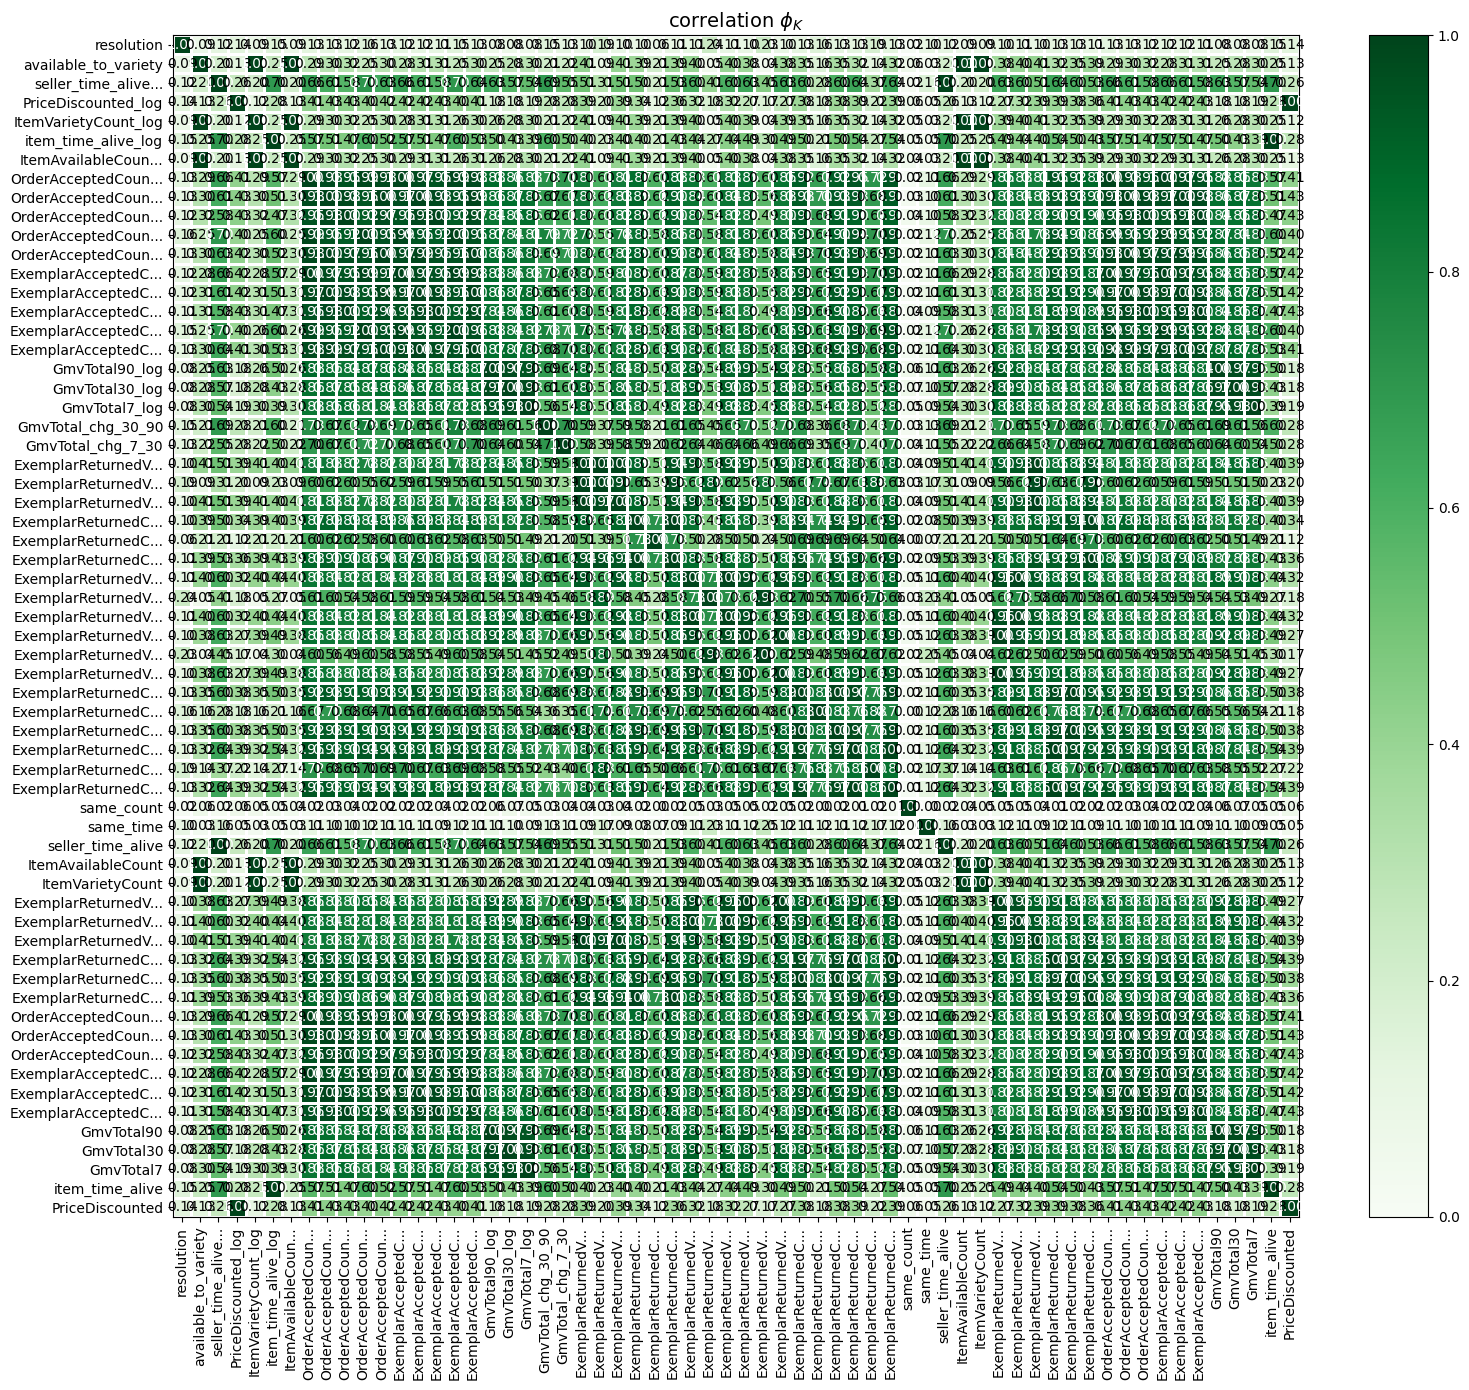

In [29]:
phik_pl_clear = df_phik.loc[:,~df_phik.T.duplicated()].copy()
phik_pl_clear.info()
mat_corr = phik_pl(phik_pl_clear, interal_col_pi)
display(mat_corr[target].sort_values(ascending=False))

In [30]:
# выделение  значимых признаков для модели на основе матрицы корреляции с порогом взаимной корреляции corr_threshold=0.9

def remove_highly_correlated_features(mat_corr,  importance_df, corr_threshold=0.9):
    """
    mat_corr - матрица корреляции
    df_features: DataFrame с признаками
    importance_df: DataFrame с колонками ['feature', 'importance'] и важностью признаков
    corr_threshold: порог корреляции для отбора 

    Возвращает список уникальных отобранных признаков с устранением избыточных.
    """
    # Рассчитываем корреляционную матрицу по признакам
    corr_matrix = mat_corr

    # Треугольник связности (без повторов)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Находим признаки, которые надо удалить (те, что имеют корреляцию выше порога)
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]

    # Группируем признаки по корреляции выше порога
    groups = []
    unchecked = set(mat_corr.columns) - set(to_drop)
    for col in to_drop:
        # Находим всех коррелирующих с этим признаком (>threshold)
        correlated = set(upper.index[upper[col] > corr_threshold].tolist())
        correlated.add(col)
        # Проверяем пересечения с уже найденными группами
        merged = False
        for group in groups:
            if not group.isdisjoint(correlated):
                group.update(correlated)
                merged = True
                break
        if not merged:
            groups.append(correlated)

    # В каждой группе оставляем только признак с максимальной важностью
    selected_features = list(unchecked)
    for group in groups:
        best_feat = max(group, key=lambda x: importance_df.loc[importance_df.feature == x, 'importance'].values[0])
        selected_features.append(best_feat)

    return list(set(selected_features))

In [118]:
importance_df = pd.DataFrame({'feature': mat_corr[target].index, 'importance': mat_corr[target]})

selected_feats_pi = remove_highly_correlated_features(mat_corr, importance_df, corr_threshold=0.9)
print(f"Отобрано признаков: {len(selected_feats_pi)}")
display(f"Признаки для жесткой фильтрации {sorted(selected_feats_pi)}")
display(f"Оставшиеся признаки  {sorted(set(mat_corr[target].index) - set(selected_feats_pi))}")
del df_phik,interal_col_pi,mat_corr

NameError: name 'mat_corr' is not defined

## Обучение Catboost на признаках , подготовленных для "жесткой фильтрации"

In [32]:
#selected_feats_pi.remove('resolution')

X = df_train1.to_pandas()[selected_feats_pi].copy()
#X['id'] = df_train1['id']
X.info()
#X.head()
for ci in X.columns:
    display(f"Количетво уникальных значений в столбеце {ci} - {X[ci].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197198 entries, 0 to 197197
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ExemplarReturnedValueTotal30_high  197198 non-null  int8   
 1   ExemplarAcceptedCountTotal7        197198 non-null  float64
 2   same_time                          197198 non-null  bool   
 3   ExemplarReturnedCountTotal30_high  197198 non-null  int8   
 4   same_count                         197198 non-null  bool   
 5   ExemplarReturnedValueTotal90_high  197198 non-null  int8   
 6   ExemplarReturnedCountTotal90_high  197198 non-null  int8   
 7   ExemplarReturnedCountTotal7_high   197198 non-null  int8   
 8   GmvTotal7                          197198 non-null  float64
 9   GmvTotal_chg_7_30                  197198 non-null  float64
 10  GmvTotal_chg_30_90                 197198 non-null  float64
 11  item_time_alive                    1971

'Количетво уникальных значений в столбеце ExemplarReturnedValueTotal30_high - 2'

'Количетво уникальных значений в столбеце ExemplarAcceptedCountTotal7 - 2504'

'Количетво уникальных значений в столбеце same_time - 2'

'Количетво уникальных значений в столбеце ExemplarReturnedCountTotal30_high - 2'

'Количетво уникальных значений в столбеце same_count - 2'

'Количетво уникальных значений в столбеце ExemplarReturnedValueTotal90_high - 2'

'Количетво уникальных значений в столбеце ExemplarReturnedCountTotal90_high - 2'

'Количетво уникальных значений в столбеце ExemplarReturnedCountTotal7_high - 2'

'Количетво уникальных значений в столбеце GmvTotal7 - 186798'

'Количетво уникальных значений в столбеце GmvTotal_chg_7_30 - 189039'

'Количетво уникальных значений в столбеце GmvTotal_chg_30_90 - 189682'

'Количетво уникальных значений в столбеце item_time_alive - 1797'

'Количетво уникальных значений в столбеце seller_time_alive - 2186'

'Количетво уникальных значений в столбеце ExemplarReturnedCountTotal90 - 1233'

'Количетво уникальных значений в столбеце ExemplarReturnedValueTotal7_high - 2'

'Количетво уникальных значений в столбеце ItemVarietyCount - 214'

'Количетво уникальных значений в столбеце PriceDiscounted - 197198'

In [117]:
# выбираем значения с небольшими nunique 
cat_cols = value_to_remove
X0 = X.drop_duplicates().copy()
X_train = X0 .drop(columns=[target])
y_train = X0[target]#df_train.to_pandas()[target]
X_train.info()
len(y_train)
#X_train.info()

KeyError: "['resolution'] not found in axis"

In [ ]:
cat_features = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]
# Настройки модели
param_grid = {        
        'depth': [12],
        'learning_rate': [0.3,0.5,0.7],
        'l2_leaf_reg': [1,3,5],
        'iterations': [400],
        'task_type': [task_type],
        'gpu_ram_part': [0.8],
        'loss_function': ['Logloss'],
        #'custom_loss': ['AUC'],
        'eval_metric': ['F1'],
        'custom_metric':['Recall'],
        'random_seed': [RANDOM_STATE],
        'early_stopping_rounds': [3],
        #'auto_class_weights':['Balanced'],
        'use_best_model': [True],
        'verbose': [1],
        'thread_count': [3],
        'allow_writing_files':[False],
        'used_ram_limit': ['12gb']
        }

# Обучение CatBoost с кроссвалидацией
cb_pipeline = CatBoostPipeline0( cat_features = cat_features,params=param_grid)
best_model = cb_pipeline.fit(X_train, y_train)
# Отчёт по модели на train
print('Лучшие параметры   ',best_model.get_params())

Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': 1} -> Mean F1: 0.7858
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': 1} -> Mean F1: 0.7987
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.7, 'loss_function': 'Logloss', 'random_

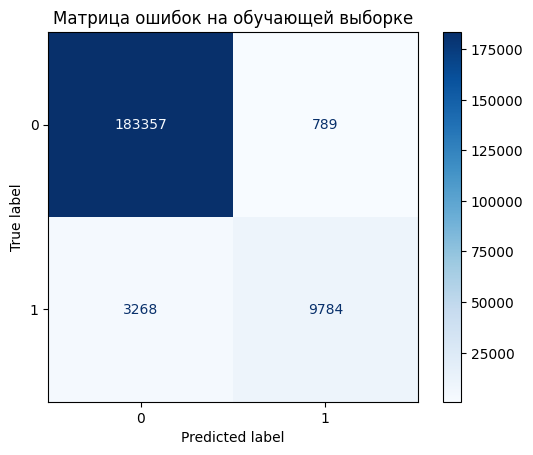

Confusion Matrix:
[[183357    789]
 [  3268   9784]]
Top 20 most important features:
                              feature  importance
15                   ItemVarietyCount   14.548552
11                    item_time_alive   12.441006
12                  seller_time_alive   12.278025
16                    PriceDiscounted   11.888943
10                 GmvTotal_chg_30_90   10.731121
8                           GmvTotal7    9.530043
13       ExemplarReturnedCountTotal90    9.041479
9                   GmvTotal_chg_7_30    8.486804
1         ExemplarAcceptedCountTotal7    7.143022
14   ExemplarReturnedValueTotal7_high    1.602747
3   ExemplarReturnedCountTotal30_high    0.902474
0   ExemplarReturnedValueTotal30_high    0.564433
2                           same_time    0.413651
5   ExemplarReturnedValueTotal90_high    0.308345
4                          same_count    0.073617
6   ExemplarReturnedCountTotal90_high    0.045736
7    ExemplarReturnedCountTotal7_high    0.000000


In [ ]:
train_preds = cb_pipeline.predict(X0.drop(columns=[target]))
print("Отчёт по обучающей выборке:")
print(classification_report(X0[target], train_preds))
ConfusionMatrixDisplay.from_estimator(best_model, X0.drop(columns=[target], X0[target], cmap=plt.cm.Blues)
plt.title("Матрица ошибок на обучающей выборке")
plt.show()

cm = confusion_matrix(X0[target], train_preds)
print("Confusion Matrix:")
print(cm)

feature_importances = best_model.get_feature_importance()

# Получить имена признаков, если X_test — pandas DataFrame
feature_names = X_train.columns

# Создать DataFrame с важностями
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Отсортировать по убыванию важности и взять топ-20
top_20 = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

print("Top 20 most important features:")
print(top_20)

In [35]:
#train_prob = cb_pipeline.predict_proba(X_train)
hard_threshold_low = 0.15
hard_threshold_high = 0.85
df_tr_pr = pd.DataFrame()
df_tr_pr['id'] =  df_train['id']

df_tr_pr['prob_1'] = cb_pipeline.predict_proba(X_train)[:,1]
df_tr_pr['pred'] = cb_pipeline.predict(X_train)
df_tr_pr[target] = df_train[target]
display(df_tr_pr[(df_tr_pr['prob_1'] < hard_threshold_high) & (df_tr_pr['prob_1'] > hard_threshold_low) & (df_tr_pr['pred'] != df_tr_pr[target]) ])


,id,prob_1,pred,resolution
419,50700,0.261860,0,1
421,141178,0.568446,1,0
440,145176,0.517019,1,0
451,270641,0.428958,0,1
574,319912,0.494124,0,1
...,...,...,...,...
197168,438899,0.584947,1,0
197176,183607,0.705256,1,0
197177,430914,0.827141,1,0
197180,246227,0.741041,1,0


### разделение train_data на hard/sort/error

In [36]:
# Группа hard предсказанных правильно

hard_mask = (df_tr_pr['prob_1'] <= hard_threshold_low) | (df_tr_pr['prob_1'] >= hard_threshold_high)
hard_objects = df_tr_pr[hard_mask & (df_tr_pr['pred'] == df_tr_pr['resolution'])]

# Сомнительные объекты (sort) для новой модели
soft_mask = (df_tr_pr['prob_1'] > hard_threshold_low) & (df_tr_pr['prob_1'] < hard_threshold_high)
soft_objects = df_tr_pr[soft_mask]

# Ошибочно классифицированные в зоне уверенности
error_mask = hard_mask & (df_tr_pr['pred'] != df_tr_pr['resolution'])
error_objects = df_tr_pr[error_mask]

# разделяем изначальные данные на три группы
df_train_hard = df_train.filter(pl.col('id').is_in(hard_objects['id'].to_list()))
df_train_soft = df_train.filter(pl.col('id').is_in(soft_objects['id'].to_list()))
df_train_error = df_train.filter(pl.col('id').is_in(error_objects['id'].to_list()))
display('Обработаные значения ',df_train_hard.to_pandas().shape[0])
display('Для дальнейшей модели ',df_train_soft.to_pandas().shape[0])
display('Аномальные значения ',df_train_error.to_pandas().shape[0])

'Обработаные значения '

184463

'Для дальнейшей модели '

11316

'Аномальные значения '

1419

In [37]:
soft_features = [f for f in all_col if f not in selected_feats_pi]
soft_features = list(set(soft_features)-set(col_drop))

df_train_soft_all = df_train_soft[soft_features].drop(text_cols,target) 

In [38]:
num_cols2 = [col for col, dtype in df_train_soft_all.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
col_num2 = list(set(num_cols2) - set(col_drop)-set(text_cols))#-set(target)
preprocessor.col_num=col_num2
#display(col_num2)
df_train_soft_processed = preprocessor.preprocess_all(df_train_soft_all, base_names_num=col_num2,drop_true=True)
df_soft_pd = df_train_soft_processed.to_pandas()

Обработка столбца item_count_fake_returns90...
Обработка столбца ExemplarReturnedValueTotal7...
Обработка столбца item_count_sales30...
Обработка столбца OrderAcceptedCountTotal7...
Обработка столбца item_count_returns30...
Обработка столбца item_count_sales90...
Обработка столбца OrderAcceptedCountTotal30...
Обработка столбца item_count_fake_returns30...
Обработка столбца ItemAvailableCount...
Обработка столбца GmvTotal30...
Обработка столбца OrderAcceptedCountTotal90...
Обработка столбца photos_published_count...
Обработка столбца item_count_returns7...
Обработка столбца item_count_returns90...
Обработка столбца rating_3_count...
Обработка столбца ExemplarReturnedCountTotal30...
Обработка столбца rating_5_count...
Обработка столбца ExemplarReturnedValueTotal30...
Обработка столбца rating_4_count...
Обработка столбца rating_2_count...
Обработка столбца rating_1_count...
Обработка столбца videos_published_count...
Обработка столбца GmvTotal90...
Обработка столбца comments_published_cou

In [39]:
#df_soft_pd
num_cols3 = [col for col, dtype in df_train_soft_processed.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
#print('num_cols2   ',num_cols2)
df_phik1 = df_soft_pd.copy()

df_phik1[target] = df_train_soft[target]

value_to_remove2 =  list(df_soft_pd.nunique()[df_soft_pd.nunique()<50].index)
interal_col_pi2 = list(set(num_cols3) - set(value_to_remove2))
#display('value_to_remove  ',value_to_remove)
#display('interal_col_pi  ',interal_col_pi)
#df_phik1.info()
#df_phik1.head(10)

In [49]:
#выбираем 30 наиболее коррелируемых признаков на основе phik параметров избегая взаимной корреляции между признаками
n_features = 30
corr_threshold = 0.8
gc.collect()
df_phik2 = df_phik1.drop_duplicates().copy()
df_phik2.columns = df_phik2.columns.map(str)
phik_pl_clear2 = df_phik2.loc[:,~df_phik2.T.duplicated()].copy()
phik_matrix2 = phik_pl_clear2.phik_matrix(interval_cols=interal_col_pi2, bins=5, quantile=True)

sorted_feats = phik_matrix2[target].sort_values(ascending=False).index

selected_feats2 = []
for feat in sorted_feats:
    gc.collect()
    if not selected_feats2:
        selected_feats2.append(feat)
    else:
        # Проверяем корреляцию с уже выбранными средствами phik
        check_feats = selected_feats2 + [feat]
        corr_matrix = phik_pl_clear2[check_feats].phik_matrix(interval_cols=interal_col_pi2, bins=5, quantile=True)
        max_corr = corr_matrix.loc[feat, selected_feats2].max()
        if max_corr < corr_threshold:
            selected_feats2.append(feat)
    if len(selected_feats2) == n_features:
        break

print("Выбранные признаки:", selected_feats2)

Выбранные признаки: ['resolution', 'ItemAvailableCount_log', 'comments_published_count_log', 'item_count_sales7_log', 'item_count_fake_returns90_to_item_count_sales90', 'item_count_fake_returns90_log', 'item_count_returns7_to_item_count_sales7', 'ExemplarReturnedCountTotal30_high', 'ExemplarReturnedValueTotal90_to_ExemplarReturnedValueTotal90', 'item_count_sales_chg_7_30', 'GmvTotal_chg_30_90', 'ExemplarReturnedCountTotal7_high', 'ExemplarReturnedValueTotal7_high', 'item_count_sales_chg_30_90', 'OrderAcceptedCountTotal7_log', 'videos_published_count_log']


In [62]:
sel = selected_feats2.copy()

In [84]:
#selected_feats2.remove('resolution')
sel = selected_feats2 #text_cols
#sel.remove('resolution')
#display(sel)
#display(selected_features_cat)
X_train_soft = pd.DataFrame()
X_train_soft[text_cols] = df_train_soft.to_pandas()[text_cols]

X_train_soft[sel] = df_soft_pd[sel]
y_soft = df_train_soft.to_pandas()[target]

cat_cols_soft = list(X_train_soft.nunique()[X_train_soft.nunique()<50].index)
cat_cols_soft.remove('item_count_fake_returns90_log')
cat_cols_soft.remove('videos_published_count_log')
X_train_soft[cat_cols_soft] = X_train_soft[cat_cols_soft]
X_train_soft[text_cols] = X_train_soft[text_cols].fillna('').astype('string')
X_train_soft.info()
display(cat_cols_soft)
cat_features_soft = [X_train_soft.columns.get_loc(c) for c in cat_cols_soft if c in X_train_soft.columns]

text_feature_indices = [X_train_soft.columns.get_loc(c) for c in text_cols if c in X_train_soft.columns]
print(text_feature_indices,cat_features_soft)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11316 entries, 0 to 11315
Data columns (total 19 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   brand_name                                                    11316 non-null  string 
 1   description                                                   11316 non-null  string 
 2   name_rus                                                      11316 non-null  string 
 3   CommercialTypeName4                                           11316 non-null  string 
 4   ItemAvailableCount_log                                        11316 non-null  float64
 5   comments_published_count_log                                  11316 non-null  float64
 6   item_count_sales7_log                                         11316 non-null  float64
 7   item_count_fake_returns90_to_item_count_sales90               11316

['ExemplarReturnedCountTotal30_high',
 'ExemplarReturnedCountTotal7_high',
 'ExemplarReturnedValueTotal7_high']

[0, 1, 2, 3] [10, 14, 15]


## Catboost soft

Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.3, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': 1} -> Mean F1: 0.8135
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': 1} -> Mean F1: 0.8062
Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.7, 'loss_function': 'Logloss', 'random_

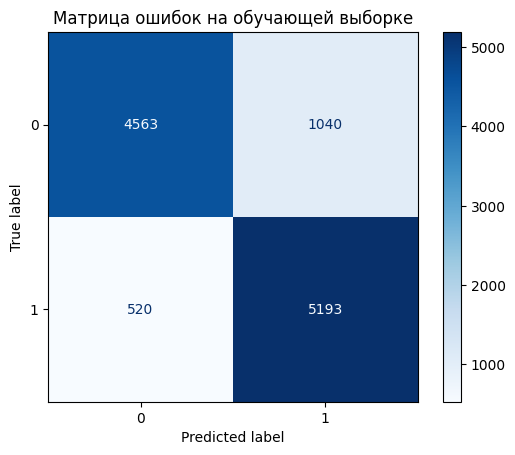

Confusion Matrix:
[[4563 1040]
 [ 520 5193]]
Top 20 most important features:
                                              feature  importance
1                                         description   26.730312
2                                            name_rus   19.390270
0                                          brand_name   14.882764
3                                 CommercialTypeName4   14.068855
4                              ItemAvailableCount_log    9.460269
13                                 GmvTotal_chg_30_90    6.291124
17                       OrderAcceptedCountTotal7_log    3.445862
11  ExemplarReturnedValueTotal90_to_ExemplarReturn...    2.614786
15                   ExemplarReturnedValueTotal7_high    1.231138
5                        comments_published_count_log    1.114405
6                               item_count_sales7_log    0.770214
10                  ExemplarReturnedCountTotal30_high    0.000000
9            item_count_returns7_to_item_count_sales7    0.000000

In [109]:
text_process = {
    'tokenizers': [
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': True,
            'token_types': ['Word'],
            'sub_tokens_policy': 'SeveralTokens'
        }
    ],
    'dictionaries': [
        {'dictionary_id': 'Word', 'max_dictionary_size': 50000},
        {'dictionary_id': 'Bigram', 'max_dictionary_size': 50000, 'gram_order': 2},
    ],
    'feature_processing': {
        'default': [
            {
                'tokenizers_names': ['Sense'],
                'dictionaries_names': ['Word', 'Bigram'],
                'feature_calcers': ['BoW:top_tokens_count=1000', 'NaiveBayes']
            }
        ]
    }
}


# Настройки модели
param_grid = {        
        'depth': [12],
        'learning_rate': [0.3,0.5,0.7],
        'l2_leaf_reg': [1],
        'iterations': [400],
        'task_type': [task_type],
        'gpu_ram_part': [0.8],
        'loss_function': ['Logloss'],
        #'custom_loss': ['AUC'],
        'eval_metric': ['F1'],
        'custom_metric':['Recall'],
        'random_seed': [RANDOM_STATE],
        'early_stopping_rounds': [3],
        #'auto_class_weights':['Balanced'],
        'use_best_model': [True],
        'verbose': [1],
        'thread_count': [3],
        'allow_writing_files':[False],
        'used_ram_limit': ['12gb'],
        
        }



# Обучение CatBoost с кроссвалидацией
cb_pipeline = CatBoostPipeline(#text_processing=text_process,
                               text_features=text_feature_indices,
                               cat_features=cat_features_soft,
                               params=param_grid)
best_model = cb_pipeline.fit(X_train_soft, y_soft)
# Отчёт по модели на train
print('Лучшие параметры   ',best_model.get_params())
train_preds = cb_pipeline.predict(X_train_soft)
print("Отчёт по обучающей выборке:")
print(classification_report(y_soft, train_preds))
ConfusionMatrixDisplay.from_estimator(best_model, X_train_soft, y_soft, cmap=plt.cm.Blues)
plt.title("Матрица ошибок на обучающей выборке")
plt.show()

cm = confusion_matrix(y_soft, train_preds)
print("Confusion Matrix:")
print(cm)

feature_importances = best_model.get_feature_importance()

# Получить имена признаков, если X_test — pandas DataFrame
feature_names = X_train_soft.columns

# Создать DataFrame с важностями
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Отсортировать по убыванию важности и взять топ-20
top_20 = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

print("Top 20 most important features:")
print(top_20)

In [116]:
df_tr_pr_soft = pd.DataFrame()
df_tr_pr_soft['id'] =  df_train_soft['id']

df_tr_pr_soft['prob_1'] = cb_pipeline.predict_proba(X_train_soft)[:,1]
df_tr_pr_soft['pred'] = cb_pipeline.predict(X_train_soft)
df_tr_pr_soft[target] = df_train_soft[target]
display(df_tr_pr[(df_tr_pr['prob_1'] < hard_threshold_high) & (df_tr_pr['prob_1'] > hard_threshold_low) & (df_tr_pr['pred'] != df_tr_pr[target]) ])

error_mask2 = hard_mask & (df_tr_pr['pred'] != df_tr_pr['resolution'])
error_objects2 = df_tr_pr[error_mask]

df_train_error2 = df_train_soft.filter(pl.col('id').is_in(error_objects['id'].to_list()))

,id,prob_1,pred,resolution
419,50700,0.261860,0,1
421,141178,0.568446,1,0
440,145176,0.517019,1,0
451,270641,0.428958,0,1
574,319912,0.494124,0,1
...,...,...,...,...
197168,438899,0.584947,1,0
197176,183607,0.705256,1,0
197177,430914,0.827141,1,0
197180,246227,0.741041,1,0


In [113]:
df_train_soft

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11316 entries, 0 to 11315
Data columns (total 58 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   item_count_fake_returns90_to_item_count_sales90               11316 non-null  float64
 1   item_count_fake_returns90_high                                11316 non-null  int8   
 2   item_count_fake_returns90_log                                 11316 non-null  float64
 3   ExemplarReturnedValueTotal7_to_ExemplarReturnedValueTotal7    11316 non-null  float64
 4   ExemplarReturnedValueTotal7_high                              11316 non-null  int8   
 5   ExemplarReturnedValueTotal7_log                               11316 non-null  float64
 6   item_count_returns30_to_item_count_sales30                    11316 non-null  float64
 7   item_count_returns30_high                                     11316